# Detect Counterfeit banknotes using Deep Learning

## Data Augmentation 

In [ ]:
#creating image dataset

In [1]:
# Data Augmentation using keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [2]:
datagen = ImageDataGenerator(rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            fill_mode = 'nearest')

In [85]:
img = load_img('Base-dataset/real/50/real50-3.jpg')
x = img_to_array(img)
x = x.reshape((1,)+ x.shape)

In [86]:
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i=0
for batch in datagen.flow(x, batch_size=1,
                         save_to_dir='preview/real/50(Real_Front)', save_prefix ='50USD-real-F', save_format='png'):
    i += 1
    if i > 650:
        break

## Data preparation

In [2]:
#Organize data into training, validation and testing dirs
%pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [1]:
import splitfolders


In [3]:
input_folder = 'preview/'

splitfolders.ratio(input_folder, output="dataset",
                  seed=42, ratio=(.7, .2, .1),
                  group_prefix=None)

Copying files: 18118 files [05:40, 53.24 files/s] 


## Build and Train CNN model

In [1]:
# All the libraries used for the project
#Libraries needed for reading the data and building a Neural Network Classifier
%matplotlib inline
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Rescaling 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from matplotlib.image import imread
import matplotlib.pyplot as plt
import itertools, collections
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import pathlib
import random
import os

# print('GPU is used.' if len(tf.config.list_physical_devices('GPU')) > 0 else 'GPU is NOT used.')
# print("Tensorflow version: " + tf.__version__)

In [2]:
#define height and width of the image
img_width=412; img_height=256

#number of batches the data has to be divided into
batch_size=64

In [3]:
#define directory containing training data
TRAINING_DIR = 'dataset/train'

#create generator to load the data from training directory
train_generator = ImageDataGenerator().flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))

Found 12677 images belonging to 8 classes.


In [4]:
#define directory containing validation data
VALIDATION_DIR = 'dataset/val'

#create generator to load the data from validation directory
validation_generator = ImageDataGenerator().flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )

Found 3622 images belonging to 8 classes.


In [5]:
#define directory containing testing data
TEST_DIR = 'dataset/test'

#create generator to load the data from testing directory
test_generator = ImageDataGenerator().flow_from_directory(TEST_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width),
                                                          shuffle=False 
                                                             )

Found 1819 images belonging to 8 classes.


### Visualize data distribution

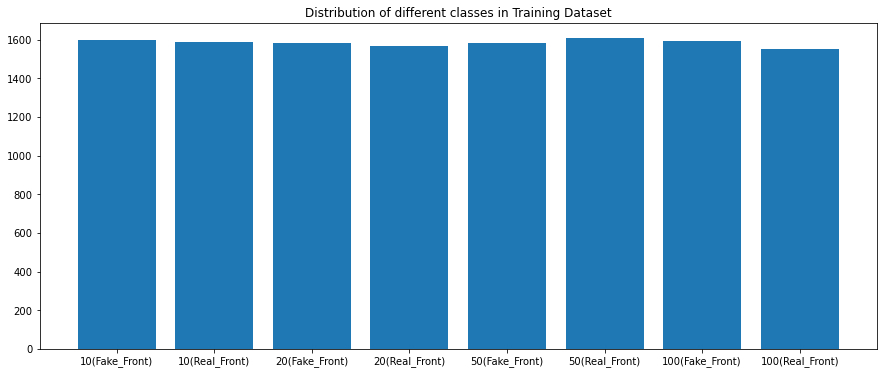

In [6]:
image_folder = ['10(Fake_Front)','10(Real_Front)','20(Fake_Front)','20(Real_Front)','50(Fake_Front)','50(Real_Front)','100(Fake_Front)','100(Real_Front)']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir('dataset/train/'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(15, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Training Dataset')
plt.show()

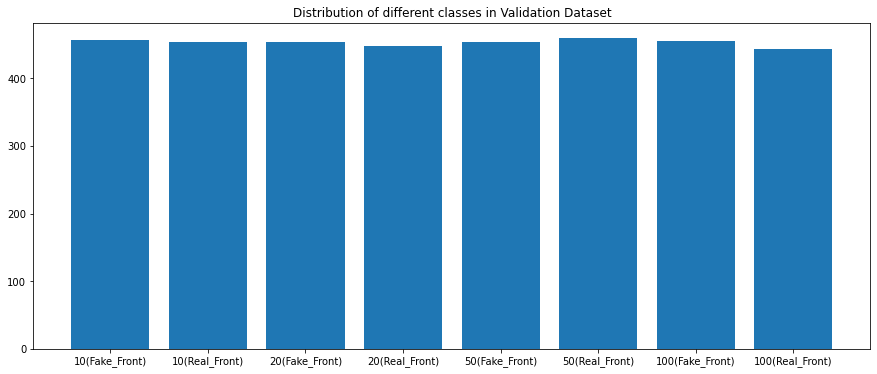

In [7]:
image_folder = ['10(Fake_Front)','10(Real_Front)','20(Fake_Front)','20(Real_Front)','50(Fake_Front)','50(Real_Front)','100(Fake_Front)','100(Real_Front)']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir('dataset/val/'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(15, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Validation Dataset')
plt.show()

In [8]:
#save the list of classes (labels).
class_names = list(train_generator.class_indices.keys())

#save the number of labels.
num_classes = train_generator.num_classes

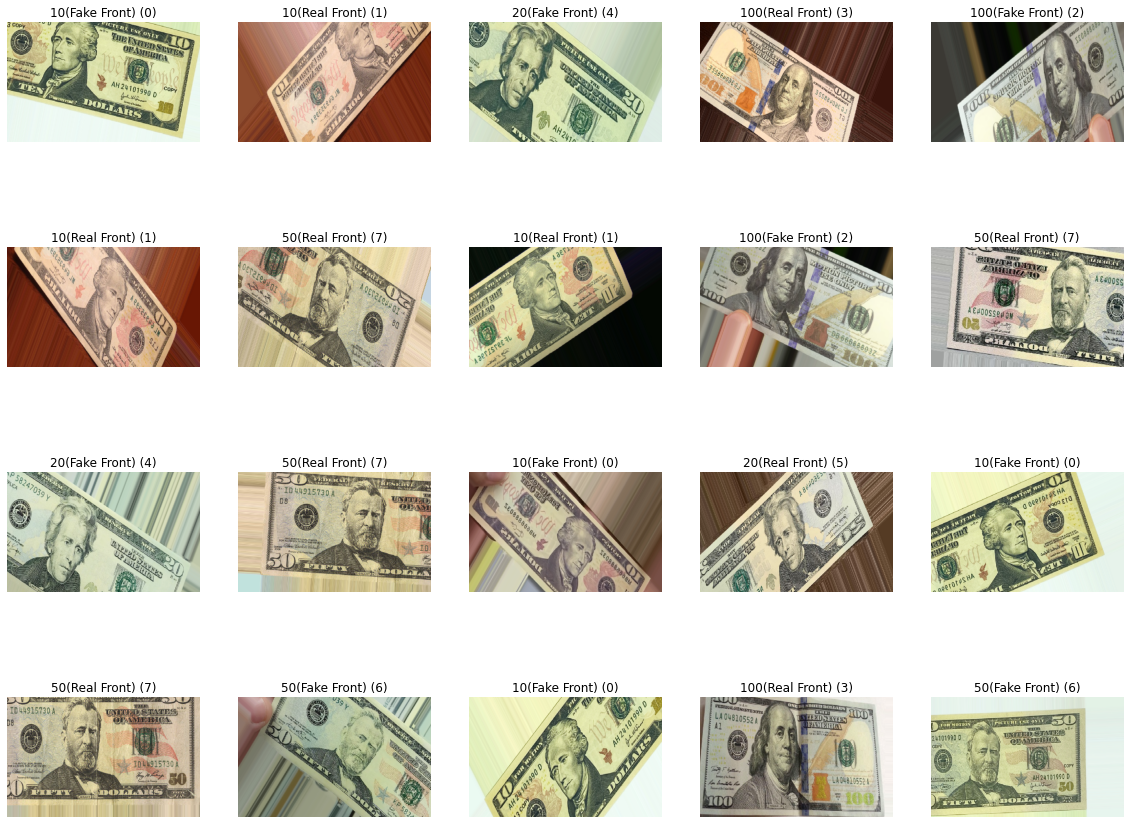

In [9]:
# Show sample of images.
plt.figure(figsize=(20, 20))
images = []
labels = []
for itr in train_generator.next():
    for i in range(20):
        if len(images) < 20:
            images.append(itr[i].astype("uint8"))
        else:
            labels.append(list(itr[i]).index(1))

for i in range(len(images)):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]].replace('_',' ') +' ('+str(int(labels[i]))+')')
    plt.axis("off")
    

In [10]:
callbacks = EarlyStopping(monitor= 'val_loss', patience=5, verbose=1, mode='auto')
#autosave best model
best_model_file = 'banknote_auth_main.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose=1, save_best_only = True)

In [11]:
#define the model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)), MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'), MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(8, activation='softmax')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 410, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 205, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 203, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 101, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 99, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 97, 64)        3

In [13]:
#compile the model before using
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics =['accuracy'])

In [14]:
#train the model
history = model.fit(train_generator,
                              epochs=10,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [best_model]
                              )

Epoch 1/10
199/199 [==============================] - 1067s 5s/step - loss: 1.9475 - accuracy: 0.3448 - val_loss: 0.9799 - val_accuracy: 0.6295
Epoch 2/10
199/199 [==============================] - 1164s 6s/step - loss: 0.5268 - accuracy: 0.8108 - val_loss: 0.1456 - val_accuracy: 0.9475
Epoch 3/10
199/199 [==============================] - 1214s 6s/step - loss: 0.2679 - accuracy: 0.9190 - val_loss: 0.2377 - val_accuracy: 0.9351
Epoch 4/10
199/199 [==============================] - 1107s 6s/step - loss: 0.0720 - accuracy: 0.9768 - val_loss: 0.0509 - val_accuracy: 0.9837
Epoch 5/10
199/199 [==============================] - 1145s 6s/step - loss: 0.0701 - accuracy: 0.9787 - val_loss: 0.1025 - val_accuracy: 0.9608
Epoch 6/10
199/199 [==============================] - 1186s 6s/step - loss: 0.0191 - accuracy: 0.9946 - val_loss: 0.0168 - val_accuracy: 0.9931
Epoch 7/10
199/199 [==============================] - 1140s 6s/step - loss: 0.6101 - accuracy: 0.8044 - val_loss: 0.1393 - val_accuracy:

In [15]:
#save the model
import os.path
if os.path.isfile('model/banknote_auth_main.h5') is False:
    model.save('model/banknote_auth_main.h5')

### Visualize training results

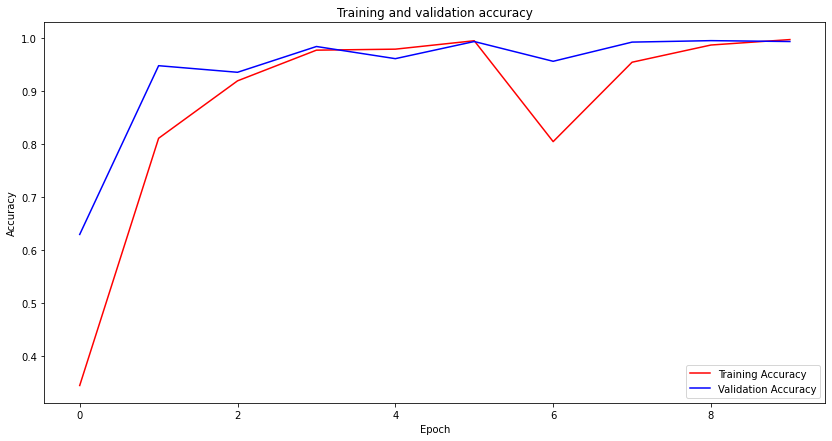

In [16]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

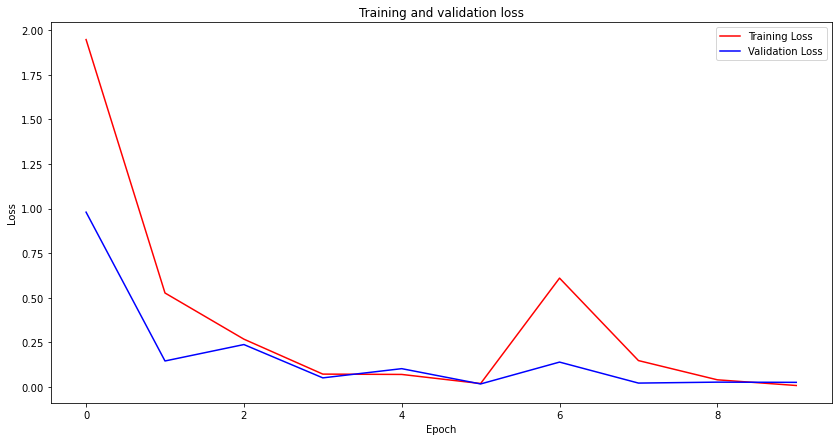

In [17]:
fig2 = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [18]:
#classification report of the model
test_generator.reset()
test_generator.shuffle = False
test_generator.next()
y_prob = model.predict(test_generator)
y_pred = y_prob.argmax(axis=-1)
y_true = test_generator.labels
print(classification_report(y_true, y_pred, target_names=class_names))

                 precision    recall  f1-score   support

 10(Fake_Front)       1.00      0.99      1.00       229
 10(Real_Front)       1.00      1.00      1.00       228
100(Fake_Front)       1.00      1.00      1.00       229
100(Real_Front)       1.00      1.00      1.00       223
 20(Fake_Front)       1.00      0.97      0.98       227
 20(Real_Front)       0.98      1.00      0.99       225
 50(Fake_Front)       0.97      1.00      0.98       227
 50(Real_Front)       1.00      0.98      0.99       231

       accuracy                           0.99      1819
      macro avg       0.99      0.99      0.99      1819
   weighted avg       0.99      0.99      0.99      1819



In [19]:
predictions = model.predict(x=test_generator, verbose=0)

In [20]:
#overall accuracy of model
y_true=test_generator.labels
y_pred=np.argmax(predictions, axis=-1)
from sklearn import metrics
print("Overall Accuracy of the model is ", metrics.accuracy_score(y_true, y_pred))

Overall Accuracy of the model is  0.9928532160527762


In [21]:
cm = confusion_matrix(y_true=test_generator.classes, y_pred=np.argmax(predictions, axis=-1))

In [22]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.magma):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        print("Normalized confusion matrix")
    else:
        cm=cm
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[227   1   0   0   0   0   0   1]
 [  0 228   0   0   0   0   0   0]
 [  0   0 229   0   0   0   0   0]
 [  0   0   0 223   0   0   0   0]
 [  0   0   0   0 220   0   7   0]
 [  0   0   0   0   0 225   0   0]
 [  0   0   0   0   0   0 227   0]
 [  0   0   0   0   0   4   0 227]]


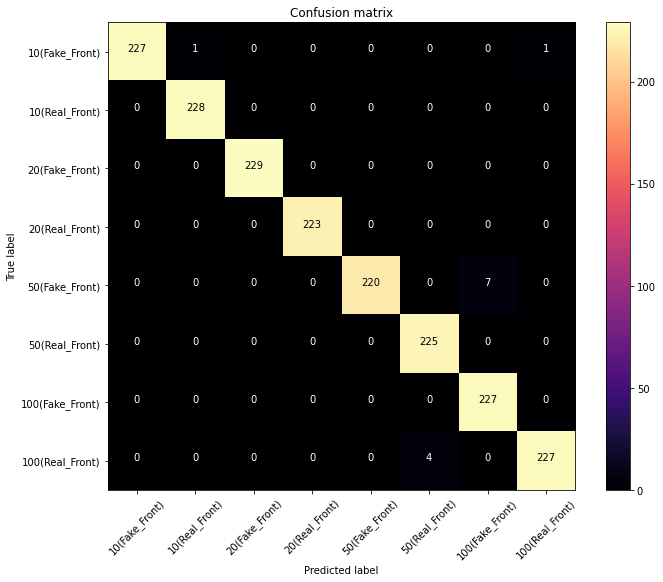

In [23]:
fig1 = plt.figure(figsize=(10,8))
cm_plot_labels = ['10(Fake_Front)','10(Real_Front)','20(Fake_Front)','20(Real_Front)','50(Fake_Front)','50(Real_Front)','100(Fake_Front)','100(Real_Front)']
plot_confusion_matrix(cm=cm, classes= cm_plot_labels, title= 'Confusion matrix')
plt.show()

### Predictions made by the model

In [24]:
from keras import models    
model = models.load_model('model/banknote_auth_main.h5', compile = False)

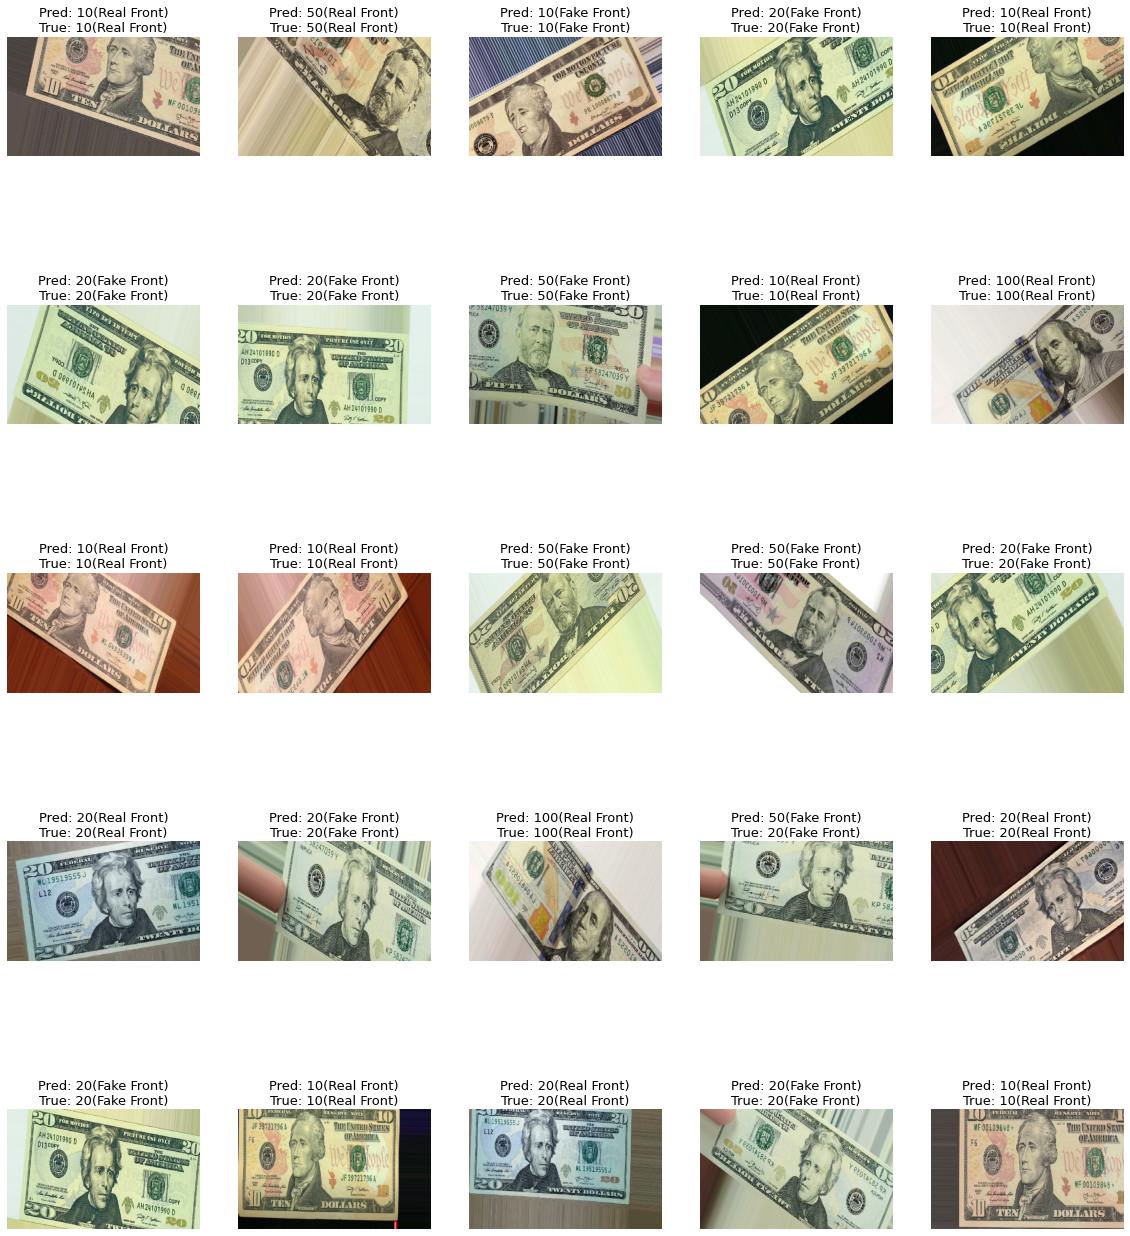

In [25]:
test_generator.reset()
test_generator.shuffle = True

#image previews
plt.figure(figsize=(20, 20))
images = []
labels_pred = []
labels_true = []
for itr in test_generator.next():
    for i in range(25):
        if len(images) < 25:
            images.append(itr[i].astype("uint8"))
            y_proba = model.predict(np.array([itr[i]]))
            y_pred = np.argmax(y_proba,axis=1)[0]
            labels_pred.append(y_pred)
        else:
            labels_true.append(list(itr[i]).index(1))
    

for i in range(len(images)):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])    
    title = 'Pred: ' + class_names[labels_pred[i]].replace('_',' ') +'\n' +'True: ' + class_names[labels_true[i]].replace('_',' ') 
    
    
    plt.title(title,fontsize= 13, pad=5)
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=0.1, right=None, top=1, wspace=None, hspace=None)